# Import

In [1]:
import numpy as np
import pandas as pd

from pyMSOO.MFEA.model import SM_MFEA
from pyMSOO.utils.Crossover import *
from pyMSOO.utils.Mutation import *
from pyMSOO.utils.Selection import *
from pyMSOO.utils.DimensionAwareStrategy import DaS_strategy

from pyMSOO.utils.EA import * 
from pyMSOO.MFEA.benchmark.continous.CEC17 import CEC17_benchmark 
from pyMSOO.MFEA.benchmark.continous.WCCI22 import WCCI22_benchmark

from pyMSOO.utils.MultiRun.RunMultiTime import * 
from pyMSOO.utils.MultiRun.RunMultiBenchmark import * 

# Run

In [2]:
import numpy as np

In [3]:
from pyMSOO.utils.Crossover import AbstractCrossover
from typing import Tuple

class SBX2_Crossover(AbstractCrossover):
    '''
    pa, pb in [0, 1]^n
    '''
    def __init__(self, nc = 15, *args, **kwargs):
        self.nc = nc

    @staticmethod
    @jit(nopython = True)
    def _crossover(gene_pa, gene_pb, swap, dim_uss, nc):
        u = np.random.rand(dim_uss)
        beta = np.where(u < 0.5, (2*u)**(1/(nc +1)), (2 * (1 - u))**(-1 / (nc + 1)))

        #like pa
        gene_oa = 0.5*((1 + beta) * gene_pa + (1 - beta) * gene_pb)
        #like pb
        gene_ob = 0.5*((1 - beta) * gene_pa + (1 + beta) * gene_pb)

        #swap
        if swap:
            idx_swap = np.where(np.random.rand(dim_uss) < 0.5)[0]
            gene_oa[idx_swap], gene_ob[idx_swap] = gene_ob[idx_swap], gene_oa[idx_swap]
    
        return gene_oa, gene_ob
        
    def __call__(self, pa: Individual, pb: Individual, skf_oa= None, skf_ob= None, *args, **kwargs) -> Tuple[Individual, Individual]:
        gene_oa, gene_ob = self.__class__._crossover(pa.genes, pb.genes, pa.skill_factor == pb.skill_factor, self.dim_uss, self.nc)

        oa = self.IndClass(gene_oa)
        ob = self.IndClass(gene_ob)

        oa.skill_factor = skf_oa
        ob.skill_factor = skf_ob
        return oa, ob

In [4]:
class func():
    dim= 2
    def __init__(self, a, b, c, d, e):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.e = e
    def __call__(self, x):
        x = x[:2]

        if 2*x[0] + x[1] > self.c or x[0] + 2*x[1] > self.d or x[0] - x[1] > self.e or x[0] < 0 or x[1] < 0:
            return 1e10
        else:
            return 1e5 - (self.a * x[0] + self.b * x[1])

In [5]:
obj_func = func(3, 2, 7, 10, 2)
obj_func.name = "obj"

n = 19
others_func = [func(np.random.randint(0, 10), np.random.randint(0, 10), np.random.randint(0, 10), np.random.randint(0, 10), np.random.randint(0, 10)) for i in range(n)]
for idx, f in enumerate(others_func):
    f.name = str(idx)

In [6]:
class Individual_func(Individual):
    def __init__(self, genes, skill_factor = None, fcost = None, parent= None, dim= None, *args, **kwargs) -> None:
        super().__init__(genes, skill_factor, fcost, parent, dim)
        if genes is None:
            self.genes: np.ndarray = np.random.rand(dim)


In [7]:
tasks, IndClass = [obj_func] + others_func, Individual_func

In [8]:
# tasks, IndClass = CEC17_benchmark.get_2tasks_benchmark(1)
# tasks, IndClass = WCCI22_benchmark.get_complex_benchmark(1)
# tasks, IndClass = CEC17_benchmark.get_10tasks_benchmark()

1 time

In [9]:
SM_SBX = SM_MFEA.model()
SM_SBX.compile(
    IndClass= IndClass,
    tasks= tasks,
    crossover= SBX2_Crossover(nc = 2),
    mutation= PolynomialMutation(nm = 5),
)
solve1 = SM_SBX.fit(
    nb_generations= 1000, nb_inds_each_task= 200, nb_inds_min= 20,
    lr = 0.1, mu=0.1,
    evaluate_initial_skillFactor= True
)

Seed: None -- Time: 01m 48.58s  100 % [====================>]  Pop_size: 3.80E+02  ,  Cost: 1.00E+05  1.00E+05  1.00E+05  1.00E+05  1.00E+10  1.00E+05  1.00E+10  1.00E+05  1.00E+10  1.00E+05  1.00E+05  1.00E+05  1.00E+05  1.00E+05  1.00E+05  1.00E+05  1.00E+10  1.00E+05  1.00E+05  1.00E+05  ,  
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
[199854, 200078, 200326, 199908, 201010, 200652, 200170, 201240, 199740, 200124, 199580, 199610, 199744, 200312, 199246, 199714, 200228, 199552, 199388, 199804]
END!


In [10]:
solve1[0]

Genes: [1.33333333 4.33333333]
Skill_factor: 0

In [11]:
- (tasks[0](solve1[0]) - 1e5)

12.66666666654055

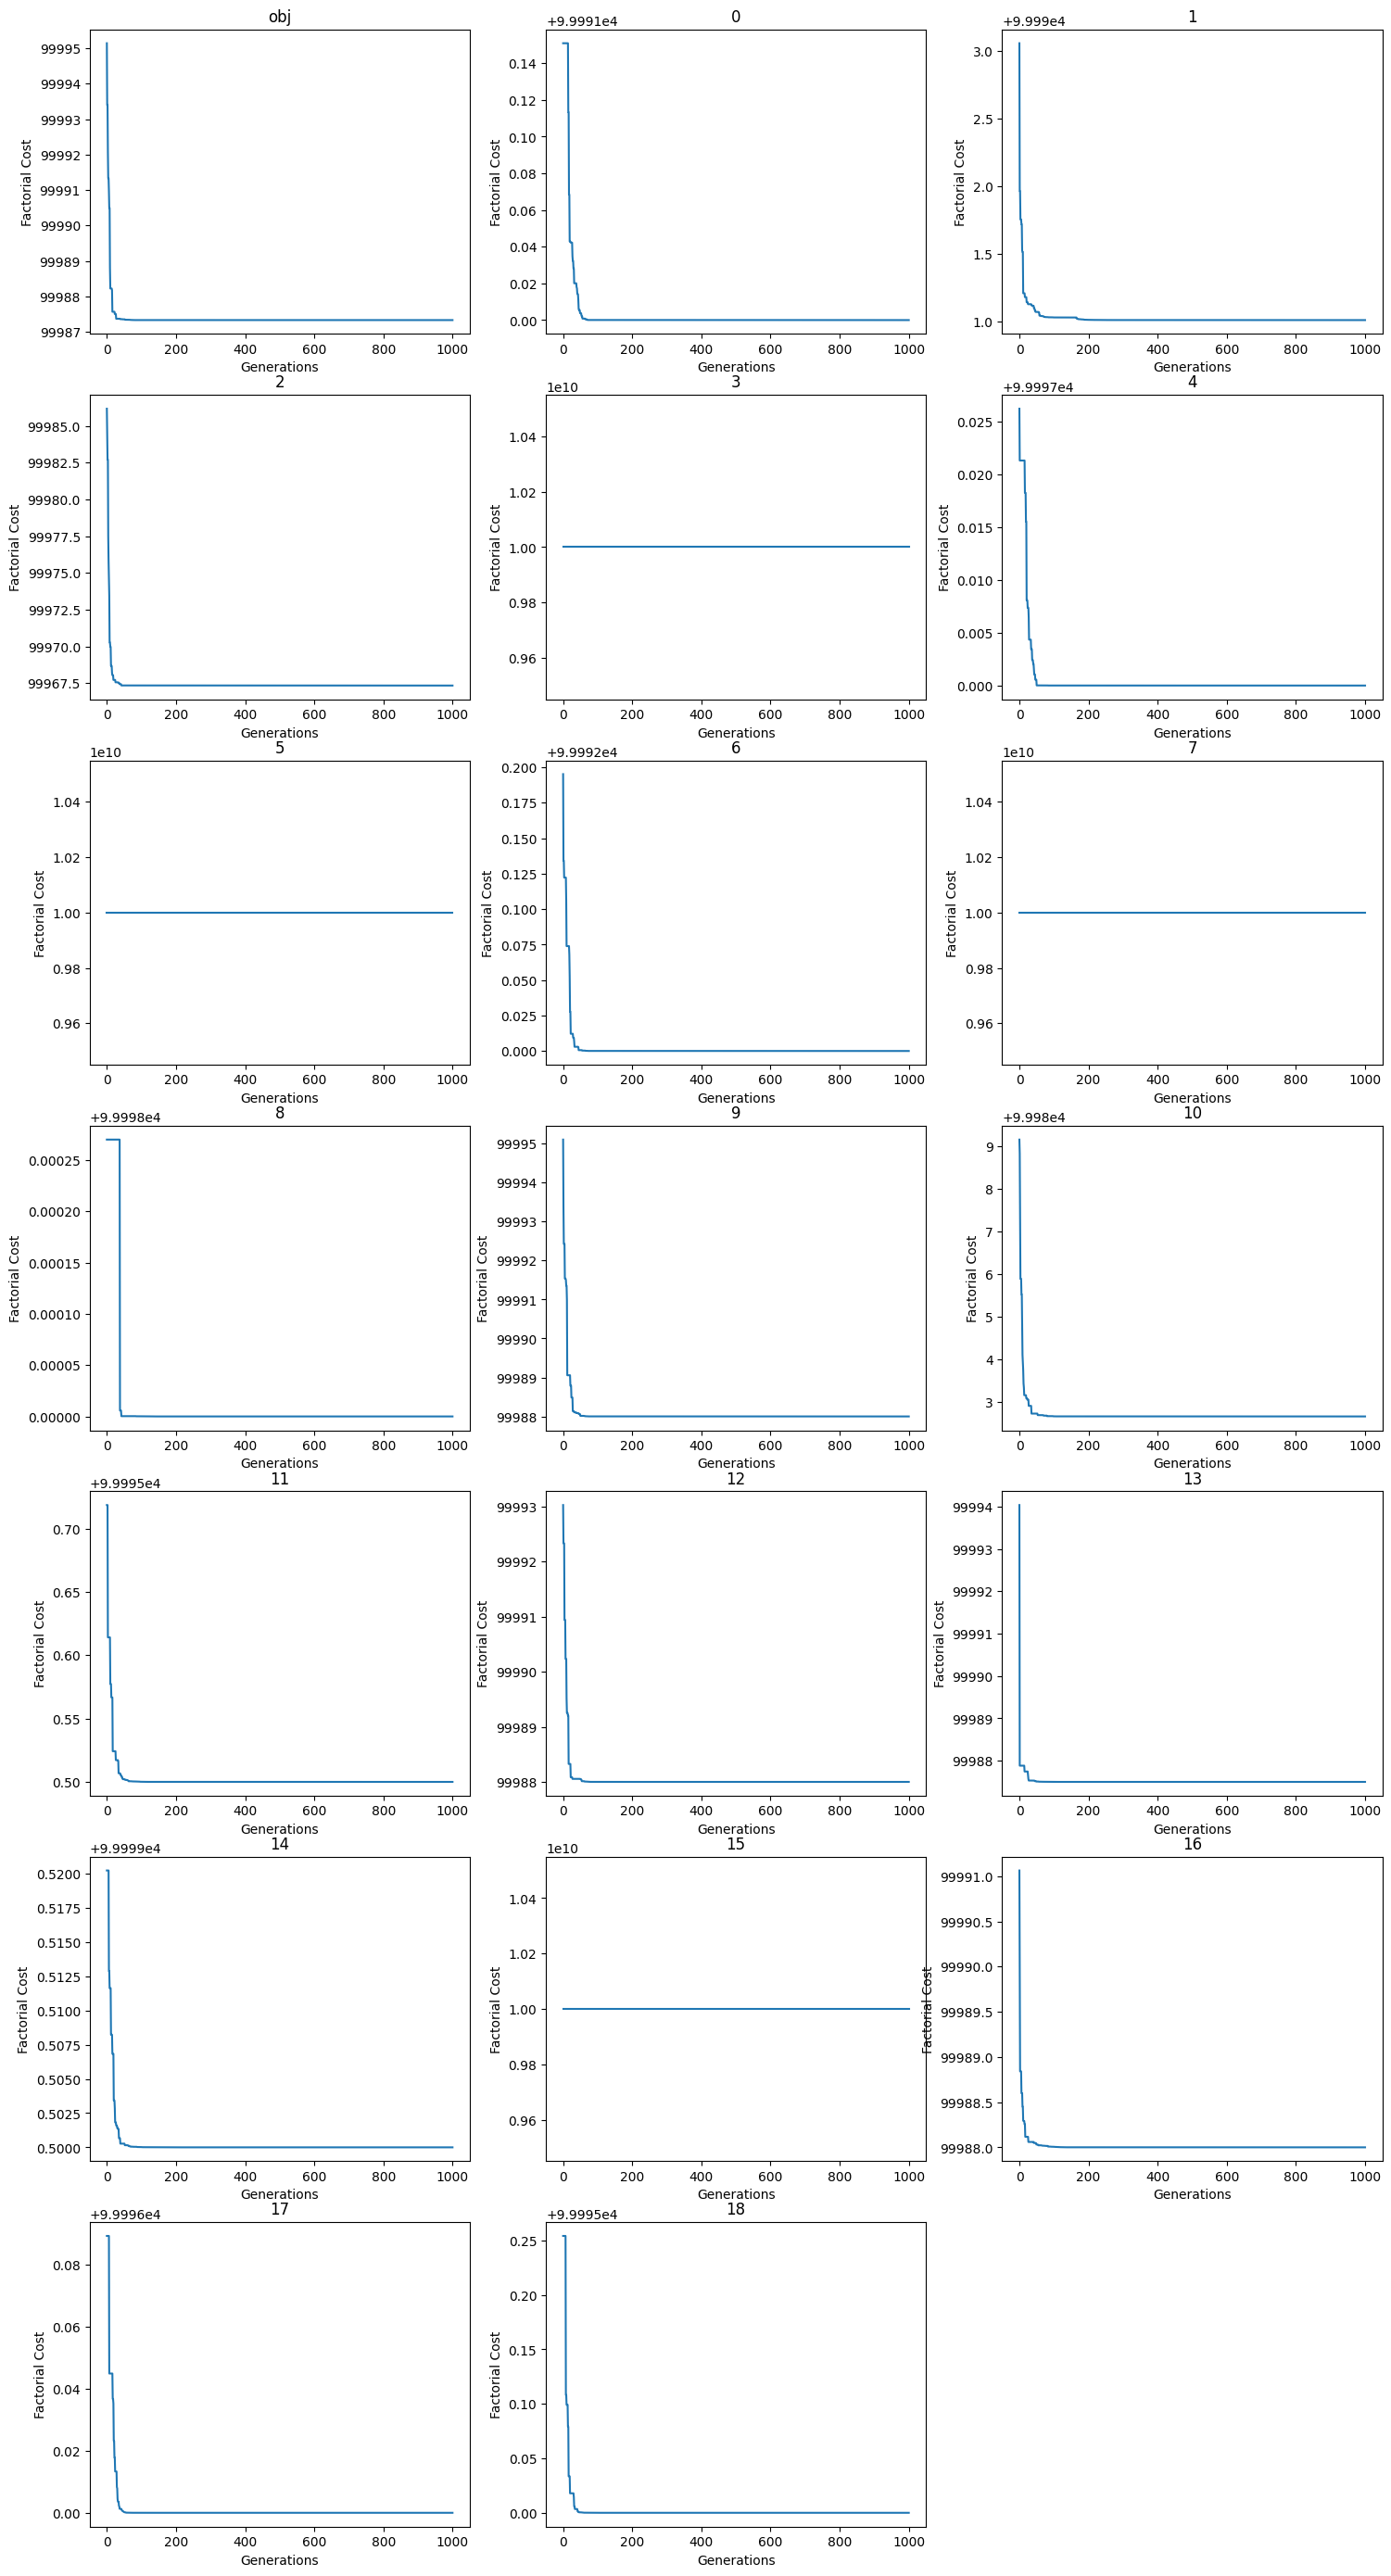

In [12]:
SM_SBX.render_history()

3


IndexError: list index out of range

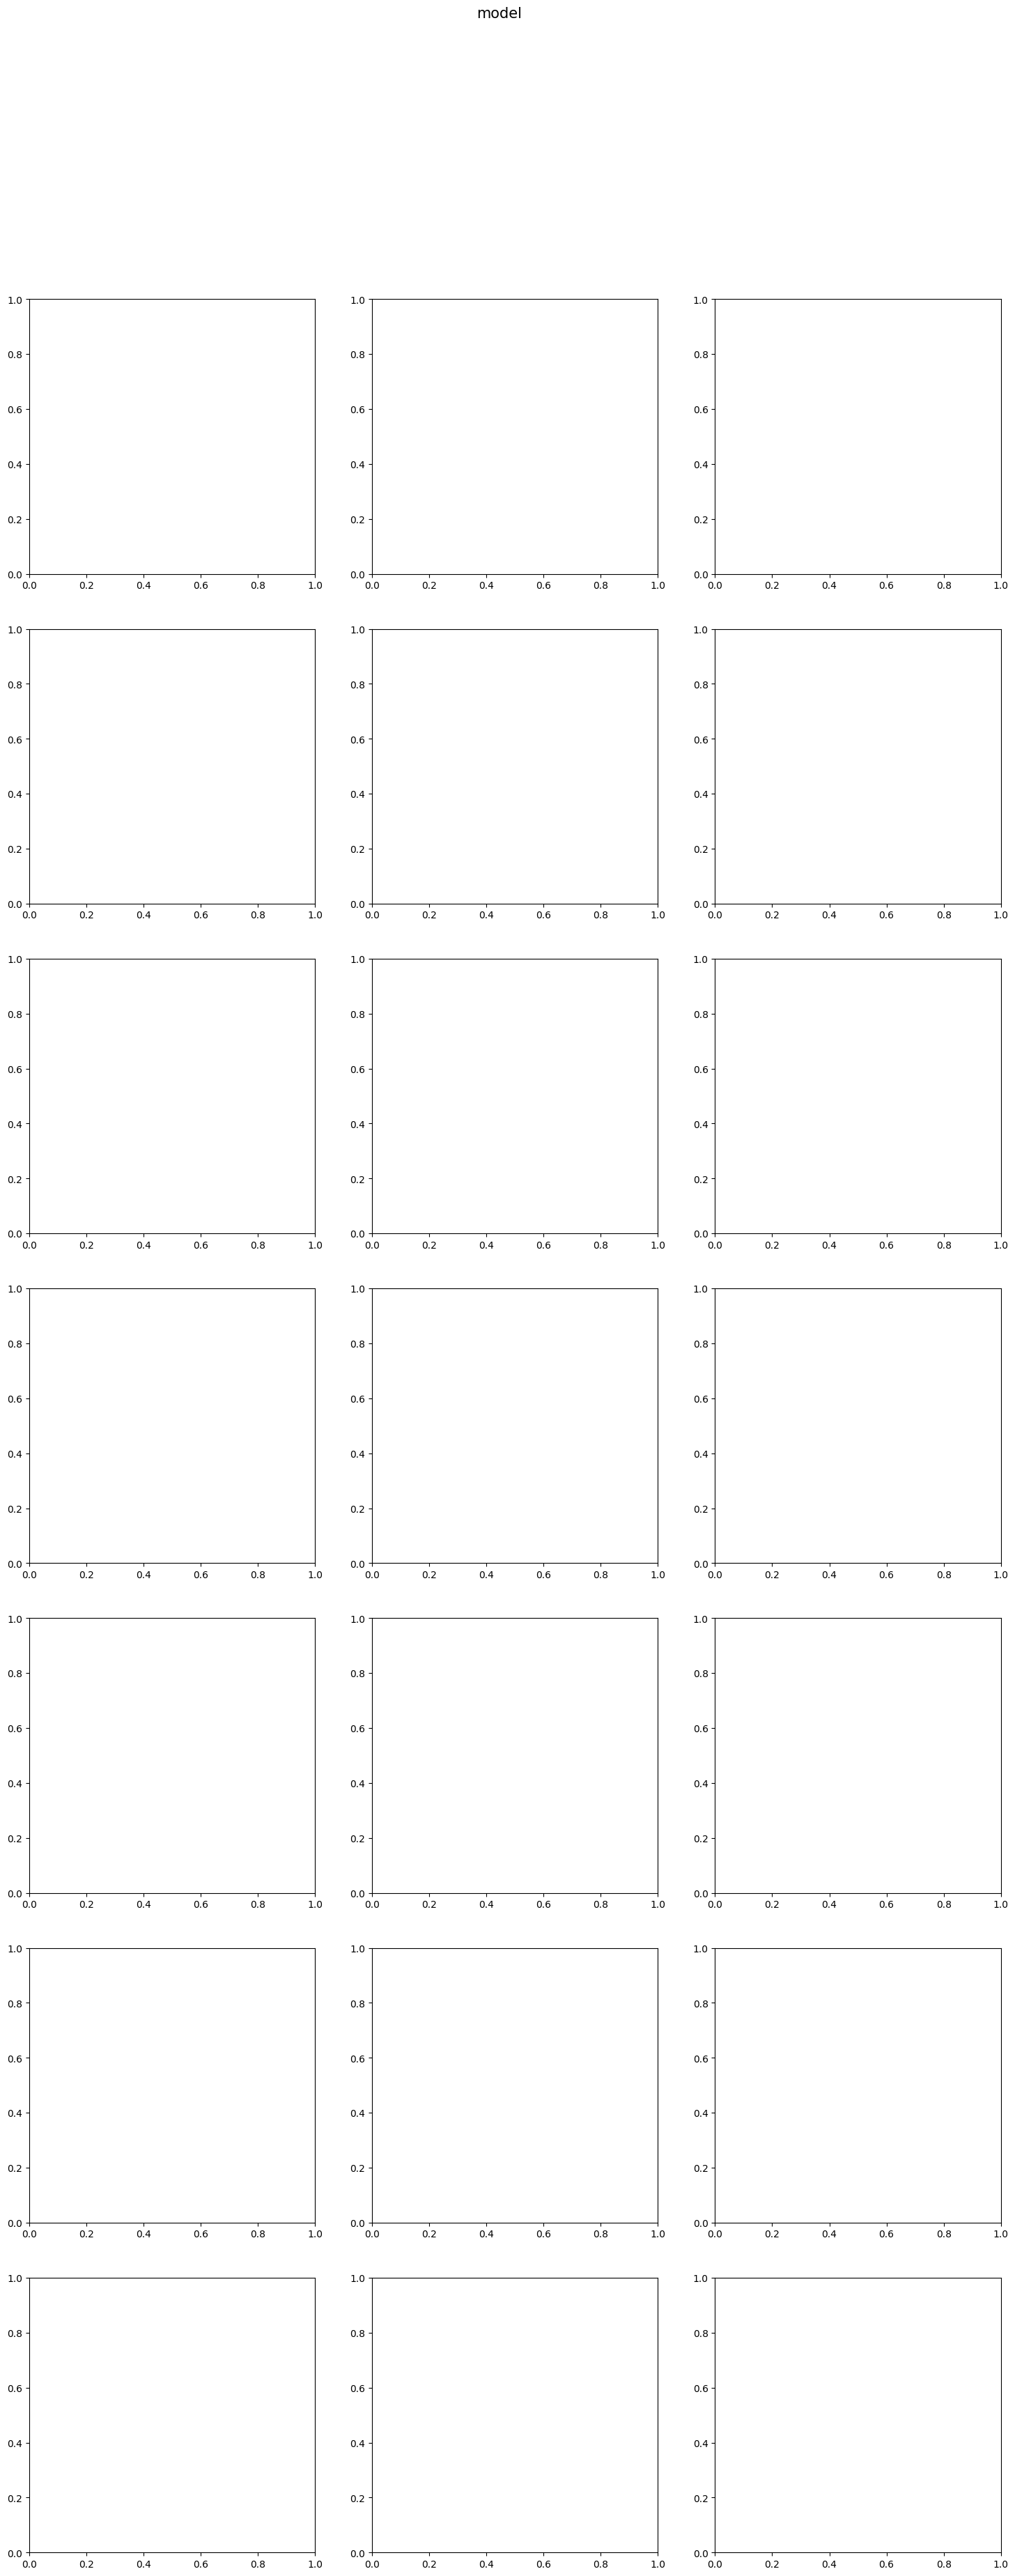

In [13]:
SM_SBX.render_smp()

In [4]:
SM_DaS = SM_MFEA.model()
SM_DaS.compile(
    IndClass= IndClass,
    tasks= tasks,
    crossover= SBX_Crossover(nc = 2),
    mutation= PolynomialMutation(nm = 5),
    dimension_strategy= DaS_strategy(eta= 3)
)
solve2 = SM_DaS.fit(
    nb_generations= 1000, nb_inds_each_task= 100, nb_inds_min= 20,
    lr = 0.1, mu=0.1,
    evaluate_initial_skillFactor= True
)

Seed: None -- Time: 02m 26.96s  100 % [====================>]  Pop_size: 1.90E+02  ,  Cost: 2.10E-26  1.86E-26  0.00E+00  0.00E+00  6.86E-23  4.31E-14  0.00E+00  1.18E+02  0.00E+00  0.00E+00  ,  
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[99838, 100258, 100214, 100418, 99598, 100142, 99806, 99114, 100240, 100402]
END!
